In [1]:
from copy import deepcopy

import cheetah
import lightning
import matplotlib.pyplot as plt
import numpy as np
import ocelot
import torch
from dataset import OcelotSpaceChargeQuadrupoleDataset
from models import SupervisedSpaceChargeQuadrupoleInference
from ocelot.adaptors.astra2ocelot import astraBeam2particleArray

/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.9/site-packages/ocelot/cpbd/beam.py:1567: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  slice_analysis = slice_analysis_py if not nb_flag else nb.jit(slice_analysis_py)
/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.9/site-packages/ocelot/cpbd/tm_utils.py:153: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavi

initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation


In [2]:
dataset_train_normalized = OcelotSpaceChargeQuadrupoleDataset(
    stage="train", normalize=True
)
dataset_train_raw = OcelotSpaceChargeQuadrupoleDataset(stage="train", normalize=False)

In [3]:
dataset_train_normalized.incoming_scaler.mean_

array([5.05004661e-04, 5.06147661e-04, 5.03950968e-04, 5.04162445e-04,
       1.50218497e-04, 1.00169147e-02, 2.49440145e-09, 5.00899975e+08])

In [4]:
dataset_train_normalized.incoming_scaler.scale_

array([2.86116004e-04, 2.86624295e-04, 2.86254609e-04, 2.85950899e-04,
       8.69046826e-05, 2.69486661e-05, 1.44115286e-09, 2.88468938e+08])

In [5]:
dataset_train_normalized.controls_scaler.mean_

array([0.27482261, 0.11984017])

In [6]:
dataset_train_normalized.controls_scaler.scale_

array([ 0.13015246, 41.61693992])

In [7]:
dataset_train_normalized.outgoing_delta_scaler.mean_

array([1.09464399e-07, 5.18431208e-07, 1.14114913e-07, 5.28390886e-07,
       2.08349384e-05, 0.00000000e+00])

In [8]:
dataset_train_normalized.outgoing_delta_scaler.scale_

array([4.28257947e-07, 2.22633437e-06, 4.48862472e-07, 2.33915760e-06,
       1.16071567e-04, 1.00000000e+00])

In [9]:
model = SupervisedSpaceChargeQuadrupoleInference.load_from_checkpoint(
    "space-charge-quadrupole/065t0j7b/checkpoints/epoch=82-step=77854.ckpt"
)
model.eval()

SupervisedSpaceChargeQuadrupoleInference(
  (net): SpaceChargeQuadrupoleMLP(
    (input_layer): Sequential(
      (0): Linear(in_features=10, out_features=512, bias=True)
      (1): Identity()
      (2): Softplus(beta=1, threshold=20)
    )
    (hidden_net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Identity()
        (2): Softplus(beta=1, threshold=20)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Identity()
        (2): Softplus(beta=1, threshold=20)
      )
    )
    (output_layer): Linear(in_features=512, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)

In [10]:
model.net

SpaceChargeQuadrupoleMLP(
  (input_layer): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): Identity()
    (2): Softplus(beta=1, threshold=20)
  )
  (hidden_net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Identity()
      (2): Softplus(beta=1, threshold=20)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Identity()
      (2): Softplus(beta=1, threshold=20)
    )
  )
  (output_layer): Linear(in_features=512, out_features=6, bias=True)
)

In [11]:
import torch


class NNSpaceChargeQuadrupole(cheetah.Quadrupole):
    """
    Neural network-based quadrupole with space charge.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Load trained neural network model
        model = SupervisedSpaceChargeQuadrupoleInference.load_from_checkpoint(
            "space-charge-quadrupole/065t0j7b/checkpoints/epoch=82-step=77854.ckpt"
        )
        model.eval()

        self._delta_predictor = model.net.to(self.device)

        self._incoming_scaler_mean = torch.tensor(
            [
                5.05004661e-04,
                5.06147661e-04,
                5.03950968e-04,
                5.04162445e-04,
                1.50218497e-04,
                1.00169147e-02,
                2.49440145e-09,
                5.00899975e08,
            ]
        ).to(self.device)
        self._incoming_scaler_scale = torch.tensor(
            [
                2.86116004e-04,
                2.86624295e-04,
                2.86254609e-04,
                2.85950899e-04,
                8.69046826e-05,
                2.69486661e-05,
                1.44115286e-09,
                2.88468938e08,
            ]
        ).to(self.device)
        self._controls_scaler_mean = torch.tensor([0.27482261, 0.11984017]).to(
            self.device
        )
        self._controls_scaler_scale = torch.tensor([0.13015246, 41.61693992]).to(
            self.device
        )
        self._outgoing_delta_scaler_mean = torch.tensor(
            [
                1.09464399e-07,
                5.18431208e-07,
                1.14114913e-07,
                5.28390886e-07,
                2.08349384e-05,
                0.00000000e00,
            ]
        ).to(self.device)
        self._outgoing_delta_scaler_scale = torch.tensor(
            [
                4.28257947e-07,
                2.22633437e-06,
                4.48862472e-07,
                2.33915760e-06,
                1.16071567e-04,
                1.00000000e00,
            ]
        ).to(self.device)

    @property
    def is_skippable(self) -> bool:
        return False

    def track(self, incoming: cheetah.Beam) -> cheetah.Beam:
        """
        Track particles through the element Quadrupole while taking into account space
        charge using a neural network delta predictor.

        NOTE: This method currently only supports `ParameterBeam`s.

        :param incoming: Beam of particles entering the element.
        :return: Beam of particles exiting the element.
        """
        if incoming is cheetah.Beam.empty:
            return incoming
        elif isinstance(incoming, cheetah.ParameterBeam):
            if self.device != incoming.device:
                raise cheetah.DeviceError

            tm = self.transfer_map(incoming.energy)
            mu = torch.matmul(tm, incoming._mu)
            cov = torch.matmul(tm, torch.matmul(incoming._cov, tm.t()))
            outgoing_without_space_charge = cheetah.ParameterBeam(
                mu,
                cov,
                incoming.energy,
                device=incoming.device,
                total_charge=incoming.total_charge,
            )

            return self._add_space_charge_delta(incoming, outgoing_without_space_charge)

        elif isinstance(incoming, cheetah.ParticleBeam):
            raise NotImplementedError(f"{type(self)} does not support ParticleBeam")
        else:
            raise TypeError(f"Parameter incoming is of invalid type {type(incoming)}")

    def _add_space_charge_delta(
        self,
        incoming: cheetah.ParameterBeam,
        outgoing_without_space_charge: cheetah.ParameterBeam,
    ) -> cheetah.ParameterBeam:
        """
        Take the normally (without space charge) tracked beam and modify it to take space charge effects into account.
        """
        incoming_parameters = torch.tensor(
            [
                incoming.sigma_x,
                incoming.sigma_xp,
                incoming.sigma_y,
                incoming.sigma_yp,
                incoming.sigma_s,
                incoming.sigma_p,
                incoming.total_charge,
                incoming.energy,
            ]
        ).to(self.device)
        controls = torch.tensor([self.length, self.k1]).to(self.device)

        incoming_parameters_normalized = (
            incoming_parameters - self._incoming_scaler_mean
        ) / self._incoming_scaler_scale
        controls_normalized = (
            controls - self._controls_scaler_mean
        ) / self._controls_scaler_scale

        outgoing_delta_normalized = self._delta_predictor(
            incoming_parameters_normalized.unsqueeze(0),
            controls_normalized.unsqueeze(0),
        )[0]

        outgoing_delta = (
            outgoing_delta_normalized * self._outgoing_delta_scaler_scale
            + self._outgoing_delta_scaler_mean
        )

        outgoing_with_space_charge = outgoing_without_space_charge.transformed_to(
            sigma_x=outgoing_without_space_charge.sigma_x + outgoing_delta[0],
            sigma_xp=outgoing_without_space_charge.sigma_xp + outgoing_delta[1],
            sigma_y=outgoing_without_space_charge.sigma_y + outgoing_delta[2],
            sigma_yp=outgoing_without_space_charge.sigma_yp + outgoing_delta[3],
            sigma_s=outgoing_without_space_charge.sigma_s + outgoing_delta[4],
            sigma_p=outgoing_without_space_charge.sigma_p + outgoing_delta[5],
        )

        return outgoing_with_space_charge

In [12]:
cheetah_quadrupole = cheetah.Quadrupole(length=torch.tensor(0.12), k1=torch.tensor(7.2))

neural_quadrupole = NNSpaceChargeQuadrupole(
    length=torch.tensor(0.12), k1=torch.tensor(7.2)
)

In [13]:
incoming = cheetah.ParameterBeam.from_astra("ACHIP_EA1_2021.1351.001")

energies = torch.linspace(1e6, 1e9, steps=50)
cheetah_outgoings = []
neural_outgoings = []
for energy in energies:
    incoming = incoming.transformed_to(energy=energy, total_charge=5e-9)

    cheetah_outgoing = cheetah_quadrupole.track(incoming)
    neural_outgoing = neural_quadrupole.track(incoming)

    cheetah_outgoings.append(cheetah_outgoing)
    neural_outgoings.append(neural_outgoing)

In [14]:
p_array_incoming = astraBeam2particleArray("ACHIP_EA1_2021.1351.001")
p_array_incoming.q_array = (
    np.array([5e-9] * p_array_incoming.size()) / p_array_incoming.size()
)

ocelot_cell = [ocelot.Quadrupole(l=0.12, k1=7.2), ocelot.Marker("dummy")]

ocelot_space_charge_outgoings = []
for energy in energies:
    p_array_incoming.E = energy.item() * 1e-9

    method = {"global": ocelot.SecondTM}
    lattice = ocelot.MagneticLattice(ocelot_cell, method=method)

    space_charge = ocelot.SpaceCharge()
    space_charge.nmesh_xyz = [63, 63, 63]
    space_charge.step = 1

    navigator = ocelot.Navigator(lattice)
    navigator.add_physics_proc(space_charge, ocelot_cell[0], ocelot_cell[-1])
    navigator.unit_step = 0.02

    p_array = deepcopy(p_array_incoming)
    _, p_array_outgoing = ocelot.track(lattice, p_array, navigator)

    ocelot_space_charge_outgoings.append(p_array_outgoing)

ocelot_simple_outgoings = []
for energy in energies:
    p_array_incoming.E = energy.item() * 1e-9

    lattice = ocelot.MagneticLattice(ocelot_cell)

    navigator = ocelot.Navigator(lattice)

    p_array = deepcopy(p_array_incoming)
    _, p_array_outgoing = ocelot.track(lattice, p_array, navigator)

    ocelot_simple_outgoings.append(p_array_outgoing)

Astra to Ocelot: charge =  5.000000000001694e-13  C
Astra to Ocelot: particles number =  100000
Astra to Ocelot: energy =  0.10731590244355117  GeV
Astra to Ocelot: s pos =  13.50890653269  m
z = 0.02 / 0.12. Applied: SpaceCharge

/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.9/site-packages/ocelot/cpbd/sc.py:188: RuntimeWarning: invalid value encountered in cast
  Xi = np.int_(np.floor(X) + 1)


z = 0.12 / 0.12. Applied: SpaceCharge

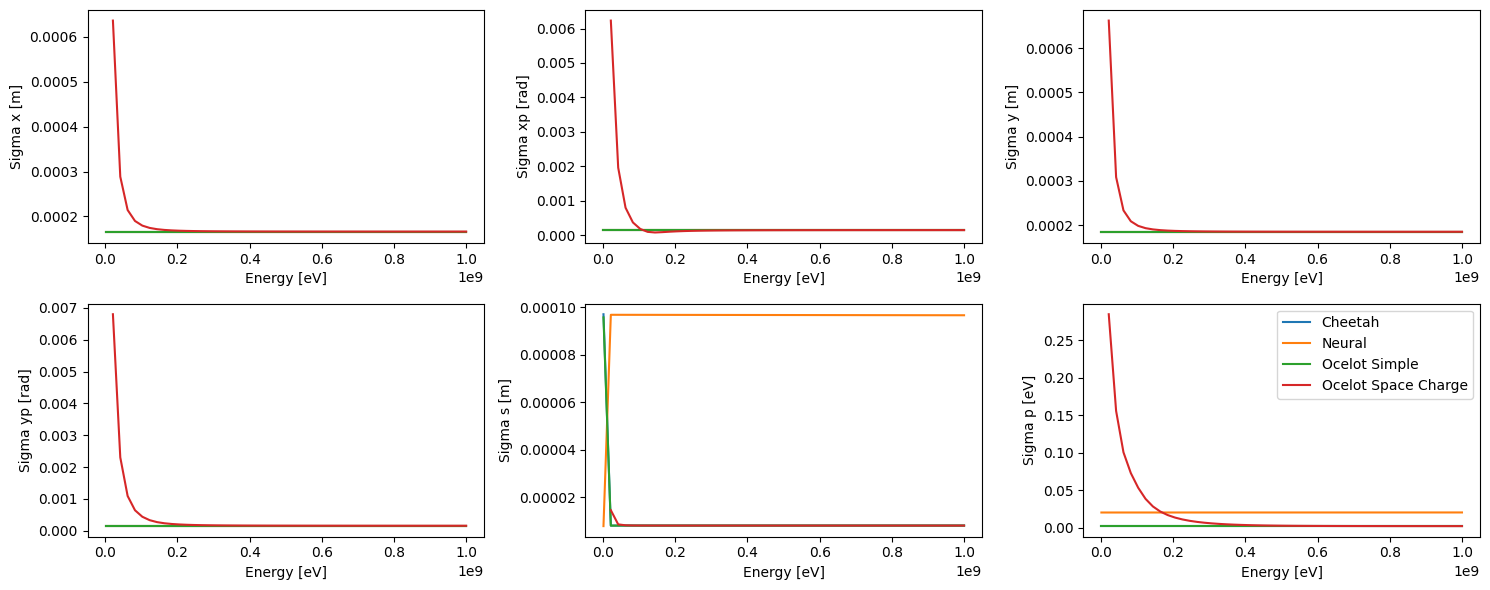

In [15]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
plt.plot(
    energies,
    [outgoing.sigma_x.detach().numpy() for outgoing in cheetah_outgoings],
    label="Cheetah",
)
plt.plot(
    energies,
    [outgoing.sigma_x.detach().numpy() for outgoing in neural_outgoings],
    label="Neural",
)
plt.plot(
    energies,
    [outgoing.x().std() for outgoing in ocelot_simple_outgoings],
    label="Ocelot Simple",
)
plt.plot(
    energies,
    [outgoing.x().std() for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot Space Charge",
)
plt.xlabel("Energy [eV]")
plt.ylabel("Sigma x [m]")
plt.subplot(2, 3, 2)
plt.plot(
    energies,
    [outgoing.sigma_xp.detach().numpy() for outgoing in cheetah_outgoings],
    label="Cheetah",
)
plt.plot(
    energies,
    [outgoing.sigma_xp.detach().numpy() for outgoing in neural_outgoings],
    label="Neural",
)
plt.plot(
    energies,
    [outgoing.px().std() for outgoing in ocelot_simple_outgoings],
    label="Ocelot Simple",
)
plt.plot(
    energies,
    [outgoing.px().std() for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot Space Charge",
)
plt.xlabel("Energy [eV]")
plt.ylabel("Sigma xp [rad]")
plt.subplot(2, 3, 3)
plt.plot(
    energies,
    [outgoing.sigma_y.detach().numpy() for outgoing in cheetah_outgoings],
    label="Cheetah",
)
plt.plot(
    energies,
    [outgoing.sigma_y.detach().numpy() for outgoing in neural_outgoings],
    label="Neural",
)
plt.plot(
    energies,
    [outgoing.y().std() for outgoing in ocelot_simple_outgoings],
    label="Ocelot Simple",
)
plt.plot(
    energies,
    [outgoing.y().std() for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot Space Charge",
)
plt.xlabel("Energy [eV]")
plt.ylabel("Sigma y [m]")
plt.subplot(2, 3, 4)
plt.plot(
    energies,
    [outgoing.sigma_yp.detach().numpy() for outgoing in cheetah_outgoings],
    label="Cheetah",
)
plt.plot(
    energies,
    [outgoing.sigma_yp.detach().numpy() for outgoing in neural_outgoings],
    label="Neural",
)
plt.plot(
    energies,
    [outgoing.py().std() for outgoing in ocelot_simple_outgoings],
    label="Ocelot Simple",
)
plt.plot(
    energies,
    [outgoing.py().std() for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot Space Charge",
)
plt.xlabel("Energy [eV]")
plt.ylabel("Sigma yp [rad]")
plt.subplot(2, 3, 5)
plt.plot(
    energies,
    [outgoing.sigma_s.detach().numpy() for outgoing in cheetah_outgoings],
    label="Cheetah",
)
plt.plot(
    energies,
    [outgoing.sigma_s.detach().numpy() for outgoing in neural_outgoings],
    label="Neural",
)
plt.plot(
    energies,
    [outgoing.tau().std() for outgoing in ocelot_simple_outgoings],
    label="Ocelot Simple",
)
plt.plot(
    energies,
    [outgoing.tau().std() for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot Space Charge",
)
plt.xlabel("Energy [eV]")
plt.ylabel("Sigma s [m]")
plt.subplot(2, 3, 6)
plt.plot(
    energies,
    [outgoing.sigma_p.detach().numpy() for outgoing in cheetah_outgoings],
    label="Cheetah",
)
plt.plot(
    energies,
    [outgoing.sigma_p.detach().numpy() for outgoing in neural_outgoings],
    label="Neural",
)
plt.plot(
    energies,
    [outgoing.p().std() for outgoing in ocelot_simple_outgoings],
    label="Ocelot Simple",
)
plt.plot(
    energies,
    [outgoing.p().std() for outgoing in ocelot_space_charge_outgoings],
    label="Ocelot Space Charge",
)
plt.legend()
plt.xlabel("Energy [eV]")
plt.ylabel("Sigma p [eV]")
plt.tight_layout()
plt.show()

In [22]:
p_array_incoming.rparticles

array([[ 5.08957129e-08,  6.15034578e-05,  2.30254514e-08, ...,
         2.08621251e-04,  5.64747744e-05, -6.26614324e-05],
       [ 5.99166607e-09,  6.28096994e-07,  6.38793974e-09, ...,
         5.50625646e-06,  1.21757376e-06, -2.37840015e-06],
       [-5.47305446e-07, -5.50215348e-07,  4.40441298e-05, ...,
         2.01889701e-04,  2.77884048e-04,  2.16434721e-04],
       [-1.22334631e-08, -1.17054384e-08,  1.65533365e-07, ...,
         6.02466623e-06,  7.84711679e-06,  6.54106916e-06],
       [-0.00000000e+00,  2.18696679e-06,  6.85092638e-07, ...,
         8.31485105e-07,  1.18904531e-06,  6.57932034e-06],
       [ 0.00000000e+00, -1.02565812e-03,  1.18559603e-03, ...,
        -5.47307162e-04,  1.43681990e-03, -1.81577163e-03]])

In [21]:
energies[0] * 1e-9

tensor(0.0010)

In [19]:
for outgoing in ocelot_space_charge_outgoings:
    print(outgoing.rparticles)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[ 2.04035853e-07  1.83175625e-04  7.29932764e-06 ...  8.01367391e-04
   2.42949862e-04 -2.43605930e-04]
 [-4.22077093e-05  1.63936731e-03  2.16400516e-05 ...  8.60054394e-03
   2.50152550e-03 -1.94047963e-03]
 [ 2.48813300e-06 -5.14711125e-06  7.62947359e-05 ...  8.53431786e-04
   1.20324603e-03  9.04727520e-04]
 [ 1.44428957e-05 -2.94230657e-05  1.01550555e-03 ...  9.73696455e-03
   1.27947994e-02  7.64605527e-03]
 [-7.49853111e-06  6.13697493e-06 -8.19154033e-06 ... -2.13209262e-08
   2.67103168e-06  2.37222296e-05]
 [ 5.60971119e-01 -8.39588941e-02  3.43395770e-01 ...  1.65487775e-01
   9.05362664e-02 -2.35801673e-01]]
[[ 5.96903855e-07  9.53682100e-05  3.40997310e-06 ...  3.91723663e-04
   1.10799070e-04 -9.71601467e-05]
 [ 1.28914010e-06  5.36681752e-04  4.03556744e-05 ...  3.04602867e-03
   8.80